In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import os

**Drop (remove) the following features**

These either have very high missingness, duplicate information, or low relevance:

- CAN_LIFE_SUPPORT: 99,99% Missing value

- CAN_PAIRED_LIVE_DONOR_ID: 99.99% Missing value and holds no useful information regarding our analysis

- CAN_CMV_STAT: 99.94% Missing value 

- CAN_C_PEPTIDE: 99.67% Missing value, C Peptide value with such high Missingness holds no information

- CAN_GROWTH_HORMONE: 98.45% Missing value 

- CAN_AVN: 98.45% Missing value

- CAN_CREAT_CLEAR & CAN_CREAT_CLEAR_DT: ≈96 % Missing value

- CAN_MM_ACPT_CD: 81.01% Missing value, holds no information 

- CAN_ANGINA: 78.43 Missing value, keep only CAN_ANGINA_CAD which is sipmpler and has less Missing values

- CAN_PULM_EMBOL:78.43% Missing value, holds no information

- CAN_DIAB: 78.39% Missing value, keep only CAN_DIAB_TY which has only about 9% Missing values

- PERS_SSA_DEATH_DT: 74.60%, no relevance because of connection to SSA database

- CAN_INIT_INACT_STAT_DT & CAN_LAST_INACT_STAT_DT: 51% Missing value, dulicate features from STATHIST_KIPA

- CAN_DIAL_DT: 43% Missing value, exact date of Dialysis not needed

- CAN_INIT_ACT_STAT_CD & CAN_INIT_ACT_STAT_DT & CAN_LAST_ACT_STAT_DT: 12% Missing value, dulicate features from STATHIST_KIPA



**Features with high Missing value but with potential importance** 

- CAN_PREV_KI_TX_FUNCTN: 99.17% Missing value, but sepcifies wether Previous Kidney Transplant is still functioning

- CAN_MALIG_TY: 94.03% Missing value and CAN_MALIG has 10% Missing value, but potentially important because it specifies which Malignancy a candidate has

- CAN_REM_COD: 91.46% Missing value, but the missing values can be justified: Candidate is not dead

- CAN_DEATH_DT: 88.65% Missing value, but the missing values can be justified: Candidate is not dead

- CAN_PREV_TXFUS: 78.43% Missing value, but the missing values can be justified: Missing value indicates that candidate had no previous transfusions

- CAN_ANGINA_CAD: 72.5% Missing value, but specifies wether candidate has ANGINA or not

- CAN_INIT_ALLOC_PRA & CAN_INIT_CUR_PRA & CAN_INIT_SRTR_PEAK_PRA & CAN_LATEST_SRTR_PEAK_PRA: around 70% Missing value, but keep for further analysis

- CAN_GFR_DT & CAN_GFR: 71.35% Missing value, but keep for further analysis

- CAN_MOST_RECENT_CREAT: 65.49% Missing value, but keep for further analysis

- PERS_OPTN_DEATH_DT: 58.24% Missing value, but can be merged with CAN_DEATH_DT for more data

- CAN_PEPTIC_ULCER: 50.73% Missing value, but keep for further analysis

- CAN_CEREB_VASC: 50.34% Missing value, but keep for further analysis

- CAN_DRUG_TREAT_HYPERTEN: 50.27% Missing value, but keep for further analysis

- CAN_DIAL: 48.99% Missing value, but keep for further analysis

- CAN_DRUG_TREAT_COPD: 45% Missing value, but keep for further analysis

- CAN_MED_COND: 42% Missing value, but keep for further analysis


**Keep (retain) the following core features**

All other columns carry essential demographic, clinical or laboratory information:

- DONOR_ID: 46% Missing value

- REC_TX_DT & REC_TX_PROCEDURE_TY: 46% Missing value

- PERS_NEXTTX_TRR_ID: 34% Missing value

- PERS_NEXTTX: 34% Missing value

- CAN_TOT_ALBUMIN: 28% Missing value

- CAN_MAX_PCT_SCLER_LT10: 14% Missing value

- CAN_MIN_PEAK_CREAT & CAN_MIN_FINAL_CREAT: 12% Missing value

- CAN_REM_CD: 12% Missing value

- CAN_RACE: 11% Missing value

- CAN_PERIPH_VASC: 11% Missing value

- CAN_MALIG: 10% Missing value

- CAN_DIAB_TY: 9% Missing value

- CAN_DGN: 8% Missing value

- CAN_ON_DIAL: 5% Missing value

- CAN_BMI: 5% Missing value

- CAN_ACTIVATE_DT: 4% Missing value

- CAN_AGE_AT_LISTING: 3% Missing value

- CAN_INIT_STAT: 3% Missing value

- CAN_WLKIPA_A1 & CAN_WLKIPA_A2 & CAN_WLKIPA_B1 & CAN_WLKIPA_B2 & CAN_WLKIPA_DR1 & CAN_WLKIPA_DR2: 3% Missing value

- CAN_LISTING_DT: 3% Missing value

- CAN_FUNCTN_STAT: 1% Missing value

- CAN_PERM_STATE: 0% Missing value

- CAN_RACE_SRTR: 0% Missing value

- CAN_ETHNICITY_SRTR: 0% Missing value

- CAN_GENDER: 0% Missing value

- WL_ORG: 0% Missing value

- CAN_ABO: 0% Missing value

- PX_ID: 0% Missing value

- CAN_SOURCE: 0% Missing value

- ORG_AR: 0% Missing value

- CAN_PREV_TX: 0% Missing value

- CAN_PREV_KI: 0% Missing value

- PERS_ID: 0% Missing value


In [2]:
subset_path = "/Users/chanyoungwoo/Thesis/extracted_subsets/cand_kipa_subset_ver1.csv"
cand = pd.read_csv(subset_path)

/var/folders/d8/czws1f3177g_k77xwyh5j8x40000gn/T/ipykernel_1108/620286928.py:2: DtypeWarning: Columns (9,16,19,21,23,34,37,40,48,49,52,56,57,58) have mixed types. Specify dtype option on import or set low_memory=False.
  cand = pd.read_csv(subset_path)


In [7]:
to_drop = [
    "CAN_LIFE_SUPPORT", "CAN_PAIRED_LIVE_DONOR_ID", 
    "CAN_CMV_STAT", "CAN_C_PEPTIDE",
    "CAN_GROWTH_HORMONE", "CAN_AVN",
    "CAN_CREAT_CLEAR", "CAN_CREAT_CLEAR_DT",
    "CAN_MM_ACPT_CD", "CAN_ANGINA",
    "CAN_PULM_EMBOL", "CAN_DIAB",
    "PERS_SSA_DEATH_DT", 
    "CAN_INIT_INACT_STAT_DT", "CAN_LAST_INACT_STAT_DT",
    "CAN_DIAL_DT", "CAN_INIT_ACT_STAT_CD",
    "CAN_INIT_ACT_STAT_DT", "CAN_LAST_ACT_STAT_DT", 
]

In [8]:
cand_clean = cand.drop(columns=to_drop)
print(f"Shape before: {cand.shape}, after drop: {cand_clean.shape}")
cand_clean.head()

Shape before: (1199290, 79), after drop: (1199290, 60)


,PERS_ID,PX_ID,WL_ORG,CAN_GENDER,CAN_ABO,CAN_RACE,CAN_RACE_SRTR,CAN_ETHNICITY_SRTR,REC_TX_PROCEDURE_TY,REC_TX_DT,...,CAN_PREV_TX,ORG_AR,CAN_INIT_SRTR_PEAK_PRA,CAN_INIT_CUR_PRA,CAN_INIT_ALLOC_PRA,CAN_LATEST_SRTR_PEAK_PRA,CAN_INIT_STAT,PERS_NEXTTX,PERS_NEXTTX_TRR_ID,DONOR_ID
0,2958459.0,-1994541.0,KI,M,O,8.0,WHITE,NLATIN,NaN,NaN,...,0.0,KI,4.0,4.0,4.0,4.0,4010.0,1997-02-12,176009.0,NaN
1,2954395.0,-1993046.0,KI,M,B,16.0,BLACK,NLATIN,NaN,NaN,...,1.0,KI,99.0,80.0,99.0,99.0,4010.0,NaN,NaN,NaN
2,2176016.0,-1980295.0,KI,F,B,16.0,BLACK,NLATIN,NaN,NaN,...,0.0,KI,13.0,13.0,13.0,13.0,4010.0,NaN,NaN,NaN
3,2670483.0,-1996133.0,KI,M,A,32.0,NATIVE,NLATIN,NaN,NaN,...,0.0,KI,0.0,0.0,0.0,0.0,4010.0,1995-12-02,163333.0,NaN
4,2919390.0,-1979910.0,KI,M,A,8.0,WHITE,NLATIN,NaN,NaN,...,0.0,KI,0.0,0.0,NaN,0.0,4010.0,NaN,NaN,NaN


,missing_pct
CAN_PREV_KI_TX_FUNCTN,99.172427
CAN_MALIG_TY,94.035638
CAN_REM_COD,91.460948
CAN_DEATH_DT,88.657789
CAN_PREV_TXFUS,78.433490
CAN_INIT_ALLOC_PRA,75.566710
CAN_ANGINA_CAD,72.501647
CAN_GFR_DT,71.582937
CAN_GFR,71.358470
CAN_INIT_CUR_PRA,68.113384


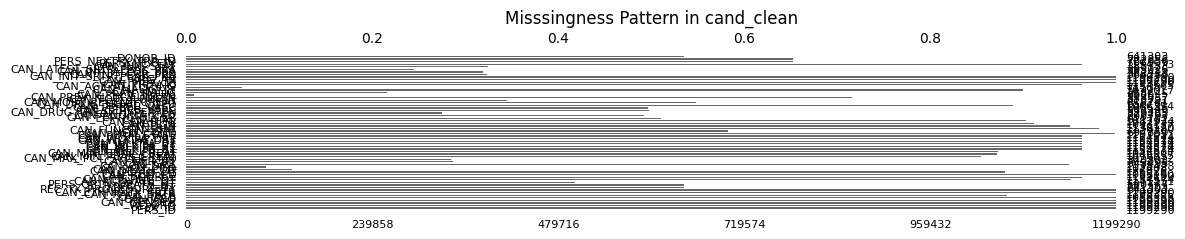

In [9]:
miss_pct = cand_clean.isna().mean().mul(100).sort_values(ascending=False)
missingness_df = miss_pct.to_frame(name="missing_pct")

display(missingness_df)

plt.figure(figsize=(12, 2))
msno.bar(cand_clean, fontsize=8, figsize=(12, 2))
plt.title("Misssingness Pattern in cand_clean")
plt.show()

In [10]:
OUT_DIR = "/Users/chanyoungwoo/Thesis/Data_Extraction/clean_subsets_ver2"
os.makedirs(OUT_DIR, exist_ok=True)

# write cand_clean to CSV
out_path = os.path.join(OUT_DIR, "cand_kipa_subset_ver2.csv")
cand_clean.to_csv(out_path, index=False)
print(f"Saved cleaned CAND_KIPA subset to {out_path}")

Saved cleaned CAND_KIPA subset to /Users/chanyoungwoo/Thesis/Data_Extraction/clean_subsets_ver2/cand_kipa_subset_ver2.csv


Analyse if there are several entrys for same PX_ID:

In [3]:
file_path = "/Users/chanyoungwoo/Thesis/Data_Extraction/clean_subsets_ver2/cand_kipa_subset_ver2.csv"
cand = pd.read_csv(file_path)
px_counts = cand["PX_ID"].value_counts()
duplicates = px_counts[px_counts > 1]

print(f"Total records: {len(cand)}")
print(f"Unique PX_IDs: {px_counts.size}")
print(f"PX_IDs with duplicates: {len(duplicates)}")

if not duplicates.empty:
    print("\nBeispiele für mehrfach vorkommende PX_IDs und deren Counts:")
    print(duplicates.head(10))
else:
    print("\nAlle PX_IDs kommen nur einmal vor.")

/var/folders/d8/czws1f3177g_k77xwyh5j8x40000gn/T/ipykernel_4918/762493943.py:2: DtypeWarning: Columns (9,15,19,38,39,44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  cand = pd.read_csv(file_path)


Total records: 1199290
Unique PX_IDs: 1199289
PX_IDs with duplicates: 1

Beispiele für mehrfach vorkommende PX_IDs und deren Counts:
PX_ID
1464647.0    2
Name: count, dtype: int64


In [ ]:
counts = cand["ORG_AR"].value_counts(dropna=False)
percents = cand["ORG_AR"].value_counts(normalize=True, dropna=False).mul(100)

org_ar_summary = pd.DataFrame({
    "count": counts,
    "percent": percents
}).sort_index()

print("--- ORG_AR distribution in CAND_KIPA subset ---")
print(org_ar_summary)

--- ORG_AR distribution in CAND_KIPA subset ---
          count    percent
ORG_AR                    
KI      1130840  94.292456
KP        49175   4.100343
PA           19   0.001584
PAK        8417   0.701832
PTA       10839   0.903785
